# Title: Sentiment Analysis with Tweeter data
## Dataset: Sentiment140
## Goal: Binary Sentiment Classification

# Load Package Dependencies

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import kagglehub # download datasets directly from kaggle
from google.colab import drive

# set seed for reproducibility
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# set directory to save images
IMAGE_OUT = os.path.join('images', 'output')
os.makedirs(IMAGE_OUT, exist_ok=True)

# Load Dataset

### Downloading Kaggle Datasets

When downloading a dataset from Kaggle, the `kagglehub` library is the easiest way to download datasets using Python. You simply provide the dataset handle (username/dataset-slug).

This is how we can get to dataset. This is provided direclty in Kaggle's website:

In [2]:
KAGGLE_DATASET_HANDLE = 'kazanova/sentiment140'

# Download the sentiment140 dataset
path = kagglehub.dataset_download(KAGGLE_DATASET_HANDLE)

print("Path to dataset files:", path)

# List the files in library
files = os.listdir(path)
print("Files downloaded:", files)

Using Colab cache for faster access to the 'sentiment140' dataset.
Path to dataset files: /kaggle/input/sentiment140
Files downloaded: ['training.1600000.processed.noemoticon.csv']


From the code above, we can see that files is a list with a single value. That is our dataset.

In [3]:
# --- Load dataset ---
DATA_PATH   = os.path.join(path, files[0])
ENCODING    = "latin-1"

# dataset doensn't have a header. Create columns names and pass it in to read_csv
cols = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(DATA_PATH, encoding=ENCODING, header=None, names=cols)

# view all values in "target" feature
print(f"Unique targets: {np.unique(df['target'])}\n")

# map target from 4 to 1
df["target"] = df["target"].map({0: 0, 4: 1})

df.head()

Unique targets: [0 4]



,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Inspect Dataset

In [4]:
# check dataset columns
print('Dataset info:')
print(df.info())

# check for missing dataset
print(f'\nMissing data:\n{df.isna().sum()}')

# check for duplicate tweets
dupe_count = df.duplicated(subset="text").sum()
print(f'\nDuplicate tweets: {dupe_count}')
print(f'Duplicate tweets ratio: {dupe_count / len(df)}')

# show a few examples
dupes = df[df.duplicated(subset='text', keep=False)].sort_values(by='text')
print(f"\nDuplicate Tweets Examples:{dupes[['text']].head(10)}")

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None

Missing data:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Duplicate tweets: 18534
Duplicate tweets ratio: 0.01158375

Duplicate Tweets Examples:                                                      text
271472     David must be hospitalized for five days end...
271505     David must be hospitalized for five days end...
1132076    bathroom is clean..... now on to more enjoya...
1132074    bathroom is clean..... now on to more enjoya...
540159    #IMISSCATH #IMISSCATH 


Label distribution: target
0    800000
1    800000
Name: count, dtype: int64



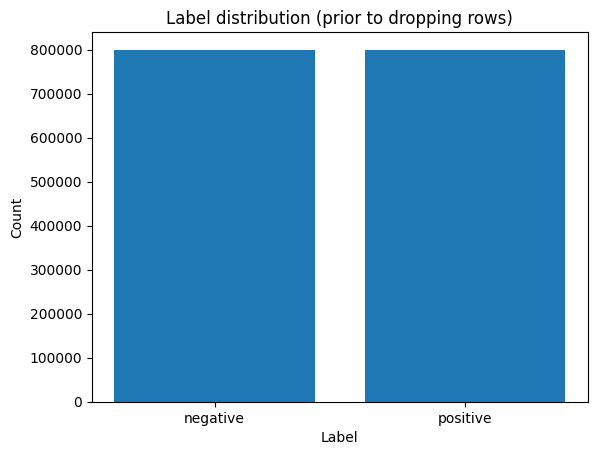

In [5]:
# check class balance
print(f"\nLabel distribution: {df['target'].value_counts()}\n")

# create bar plot of label distribution
plt.figure()
plt.bar(df["target"].unique(), df["target"].value_counts())
plt.title("Label distribution (prior to dropping rows)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(df["target"].unique(), labels=['negative', 'positive'])
plt.show()

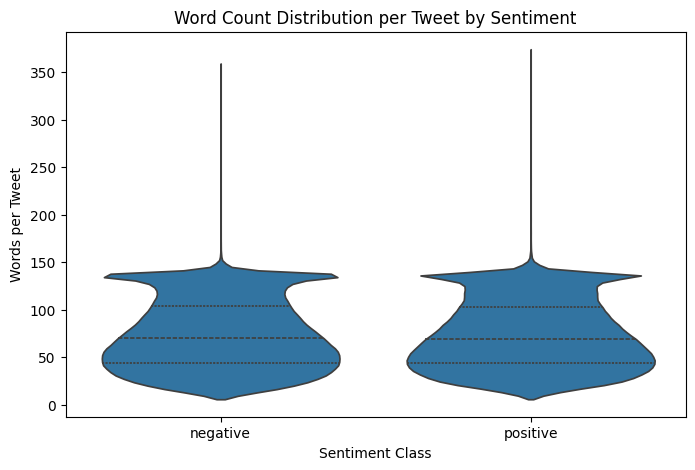

In [6]:
# check max and min tweet length
df["tweet_len_chars"] = df["text"].astype(str).str.len()
df["tweet_len_words"] = df["text"].astype(str).str.split().map(len)

# summary by class
df.groupby("target")[["tweet_len_chars", "tweet_len_words"]].agg(["count","mean","median","std","min","max"])

# violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x="target",
    y="tweet_len_chars",
    inner="quartile",
    cut=0
)

plt.title("Word Count Distribution per Tweet by Sentiment")
plt.xlabel("Sentiment Class")
plt.ylabel("Words per Tweet")
plt.xticks(df["target"].unique(), labels=['negative', 'positive'])
plt.show()


In [7]:
# generate tokens
df["tokens_raw"] = df["text"].astype(str).str.split()

# overall vocab size
vocab_raw = set(t for toks in df["tokens_raw"] for t in toks)
print(f'Vocab size (pre cleaning): {len(vocab_raw)}')

Vocab size (pre cleaning): 1350598


In [8]:
# most frequent words per class
def top_tokens_by_class(df, target_col="target", tokens_col="tokens_raw", top_k=30):
    out = {}
    for label, g in df.groupby(target_col):
        counts = Counter(t for toks in g[tokens_col] for t in toks)
        out[label] = pd.DataFrame(counts.most_common(top_k), columns=["token", "count"])
    return out

top_words = top_tokens_by_class(df, top_k=30)

for label, tdf in top_words.items():
    print(f"\n=== target = {label} (top tokens, raw) ===")
    display(tdf)


=== target = 0 (top tokens, raw) ===


,token,count
0,to,306518
1,I,299822
2,the,241000
3,a,175824
4,my,166917
5,i,160132
6,and,140240
7,is,118126
8,in,108421
9,for,96298



=== target = 1 (top tokens, raw) ===


,token,count
0,the,246501
1,to,246444
2,I,196797
3,a,190388
4,you,138383
5,and,135023
6,for,113503
7,my,113108
8,is,99567
9,in,93873


In [9]:
# check for how many tweets have URL, @ mention, or hashtags as these can add noise to the dataset
df["has_url"] = df["text"].str.contains("http")
df["has_mention"] = df["text"].str.contains("@")
df["has_hashtag"] = df["text"].str.contains("#")

df[["has_url","has_mention","has_hashtag"]].mean()

,0
has_url,0.043864
has_mention,0.466520
has_hashtag,0.023008


Dataset inspection offers a few insights off the bat that will inform data preprocessing:
* Duplicate tweets: There are 18534 duplicate tweets in the dataset I will need to drop
* Target distribution: This is evently split 50/50 for positive and negative sentiment
* Target value: originally dataset include a value of 4 for positive tweets. I changed it to 1.
* MAX_LEN: on average, tweets look to be about 74 words in length. This will help us set the appropriate MAX_LEN value.
* VOCAB_SIZE: vocabulary size is over 1 million tokens. Likely will cap the vocabulary size and use OOV tokens.
* Most common words per sentiment: The most common words are mostly stopwords. Depending on the model you could remove stopword, however, I'm trying a BiLSTM model, so I'll leave them in for context. On the positive sentiment class we start seeing words like "good" and "love" towards the end of the list.
* Noisy in data: tweets look to be mostly clean with a few tweets including "HTTP", "@", or "#". I'll remove them before training the model.

# Preprocess Dataset

In [10]:
# --- text preprocessing ---
# drop duplicate tweets
df.drop_duplicates(subset="text", keep="first", inplace=True)
print(f'Duplicate tweets: {df.duplicated(subset="text").sum()}')
print(f'\nLabel distribution: {df['target'].value_counts(normalize=True)}')

# get values
texts = df["text"].values
labels = df["target"].values.astype(int)


Duplicate tweets: 0

Label distribution: target
1    0.500347
0    0.499653
Name: proportion, dtype: float64


In [11]:
def clean_tweet(t: str) -> str:
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+", " <URL> ", t)
    t = re.sub(r"@\w+", " <USER> ", t)
    t = re.sub(r"#(\w+)", r"\1", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# clean text
df["text_clean"] = df["text"].astype(str).apply(clean_tweet)

# print samples of clean text against original
print("Cleaned text examples:")
for i in range(5):
    print(f"Original: {df['text'][i]}")
    print(f"Cleaned : {df['text_clean'][i]}")
    print('-'*50)
    print()

Cleaned text examples:
Original: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Cleaned : <USER> <URL> - awww, that's a bummer. you shoulda got david carr of third day to do it. ;d
--------------------------------------------------

Original: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Cleaned : is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!
--------------------------------------------------

Original: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Cleaned : <USER> i dived many times for the ball. managed to save 50% the rest go out of bounds
--------------------------------------------------

Original: my whole body feels itchy and like its on fire 
Cleaned : my whole body feels itchy and like its on fire
----------------------------------------

## Split dataset

Here I split the dataset into training, validation, and test data by calling train_test_split function twice. First time I split 80/20 on the dataset, giving me 80% training data and 20% I assigned to temp. The second time I included temp as input and split it 50/50, giving me a resulting 10% of the dataset as validation data and the ramining 10% is my testing data.

In [12]:
# get tweets and labels from dataset
texts_clean = df["text_clean"].values
labels = df["target"].values.astype(int)

# split data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts_clean, labels, test_size=0.2, random_state=SEED, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# Confirm data splits
n_rows = df.shape[0]
print('--- X split ---')
print(f"{'Train size:':<12} {len(X_train):<8} | Percent of total: {len(X_train)/n_rows:.2%}")
print(f"{'Val size:':<12} {len(X_val):<8} | Percent of total: {len(X_val)/n_rows:.2%}")
print(f"{'Test size:':<12} {len(X_test):<8} | Percent of total: {len(X_test)/n_rows:.2%}")

print('\n--- y split ---')
print(f"{'Train siez:':<12} {len(y_train):<8} | Percent of total: {len(y_train)/n_rows:.2%}")
print(f"{'Val size:':<12} {len(y_val):<8} | Percent of total: {len(y_val)/n_rows:.2%}")
print(f"{'Test size:':<12} {len(y_test):<8} | Percent of total: {len(y_test)/n_rows:.2%}")

--- X split ---
Train size:  1265172  | Percent of total: 80.00%
Val size:    158147   | Percent of total: 10.00%
Test size:   158147   | Percent of total: 10.00%

--- y split ---
Train siez:  1265172  | Percent of total: 80.00%
Val size:    158147   | Percent of total: 10.00%
Test size:   158147   | Percent of total: 10.00%


Now that I understand the data better and I have cleaned it and split into train, validation, and test sets, I'll create a baseline model, then tune hyparameters and/or adjust model structure to see how I can make improvements.

Below are helper functions that I'll use to tokenize and pad the cleaned tweets, build the model, train it, and finally evaluate it

## Tokenize and Pad tweets

In [13]:
def tokenize_and_pad(x_train, x_val, x_test, max_words, max_len):

    # inialize tokenizer
    tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # convert texts to sequnces
    train_seq = tokenizer.texts_to_sequences(x_train)
    val_seq   = tokenizer.texts_to_sequences(x_val)
    test_seq  = tokenizer.texts_to_sequences(x_test)

    # pad train dataset
    X_train_pad = pad_sequences(train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
    X_val_pad   = pad_sequences(val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
    X_test_pad  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

    return X_train_pad, X_val_pad, X_test_pad, tokenizer

def build_and_train_model(x_train_pad, y_train, x_val_pad, y_val, max_words, max_len, epochs=10, batch_size=1024, reg=0.0, spatial_dropout=0.2):

    # build model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(MAX_LEN,)),
        tf.keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=128),
        tf.keras.layers.SpatialDropout1D(spatial_dropout),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.4, kernel_regularizer=regularizers.l2(reg))),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    # build compiler
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
            ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            patience=2,
            factor=0.5,
            min_delta=0.002,
            min_lr=1e-6
            )
    ]

    # train model
    history = model.fit(
        x_train_pad, y_train,
        validation_data=(x_val_pad, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test_pad, y_test):
    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
    print(f"\nTest accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")
    return test_loss, test_acc

def predict_and_evaluate(model, X_test_pad, y_test, batch_size=1024):
    y_prob = model.predict(X_test_pad, batch_size=BATCH_SIZE).ravel()
    y_pred = (y_prob >= 0.5).astype(int) # convert probability to binary
    return y_prob, y_pred

def plot_history(history, title_prefix=""):
    # accuracy and loss values
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']

    # define epochs
    epochs = range(1, len(acc) + 1)

    # loss
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title(f'{title_prefix} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(os.path.join(IMAGE_OUT, "loss_curve.png"))
    plt.show()

    # accuracy
    print()
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title(f'{title_prefix} - Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(os.path.join(IMAGE_OUT, 'accuracy_curve.png'))
    plt.show()

def eval_and_viz(model_name, y_test, y_prob, y_pred):
    acc = accuracy_score(y_test, y_pred)

    print(f"\n[{model_name}] Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["neg","pos"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.savefig(os.path.join(IMAGE_OUT, f"confusion_matrix_{model_name}.png"))
    plt.show()

# Iteration 0 (baseline model)

In [14]:
MAX_WORDS = 25000
MAX_LEN = 40
EPOCHS = 15
BATCH_SIZE = 512
SPATIAL_DROPOUT = 0.2

X_train_pad, X_val_pad, X_test_pad, tokenizer = tokenize_and_pad(
    x_train   = X_train,
    x_val     = X_val,
    x_test    = X_test,
    max_words = MAX_WORDS,
    max_len   = MAX_LEN
    )
model0, history0 = build_and_train_model(
    x_train_pad     = X_train_pad,
    y_train         = y_train,
    x_val_pad       = X_val_pad,
    y_val           = y_val,
    max_words       = MAX_WORDS,
    max_len         = MAX_LEN,
    epochs          = EPOCHS,
    batch_size      = BATCH_SIZE,
    spatial_dropout = SPATIAL_DROPOUT
    )

Epoch 1/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - accuracy: 0.7731 - loss: 0.4707 - val_accuracy: 0.8195 - val_loss: 0.3960 - learning_rate: 0.0010
Epoch 2/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8217 - loss: 0.3957 - val_accuracy: 0.8243 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 3/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8308 - loss: 0.3791 - val_accuracy: 0.8262 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 4/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8365 - loss: 0.3677 - val_accuracy: 0.8271 - val_loss: 0.3877 - learning_rate: 0.0010
Epoch 5/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8439 - loss: 0.3545 - val_accuracy: 0.8275 - val_loss: 0.3934 - learning_rate: 5.0000e-04
Epoch 6/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8473 - loss: 0.3471 - val_accuracy: 0.8274 - val_loss: 0.3954 - learning_rate: 5.0000e-04
Epoch 7/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accu

### Model Evaluation

In [15]:
test_loss0, test_acc0 = evaluate_model(model0, X_test_pad, y_test)

y_prob0, y_pred0 = predict_and_evaluate(model0, X_test_pad, y_test)

4943/4943 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8276 - loss: 0.3844

Test accuracy: 0.8263 | Test loss: 0.3854
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step



[Baseline] Test Accuracy: 0.8263
              precision    recall  f1-score   support

           0     0.8343    0.8139    0.8240     79019
           1     0.8186    0.8386    0.8285     79128

    accuracy                         0.8263    158147
   macro avg     0.8265    0.8263    0.8262    158147
weighted avg     0.8265    0.8263    0.8262    158147



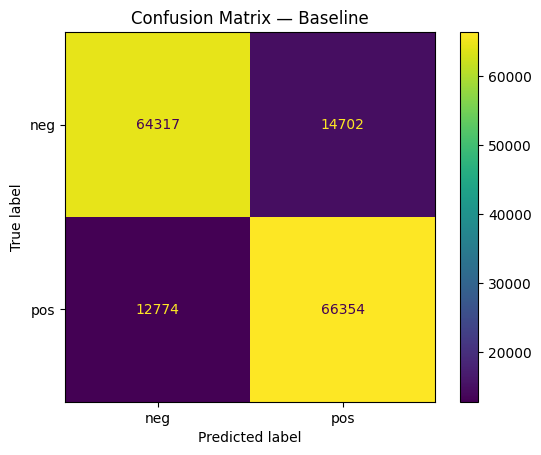

In [16]:
eval_and_viz("Baseline", y_test, y_prob0, y_pred0)

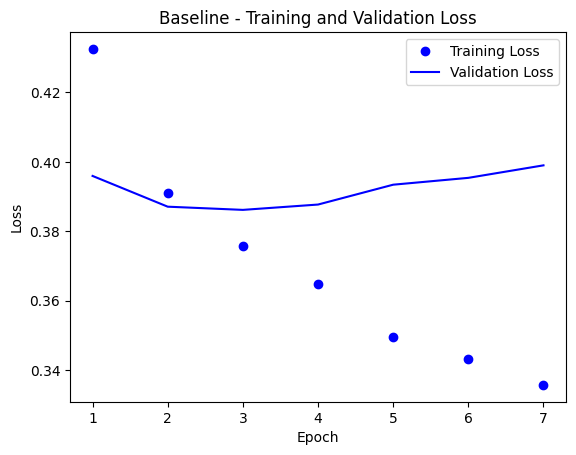

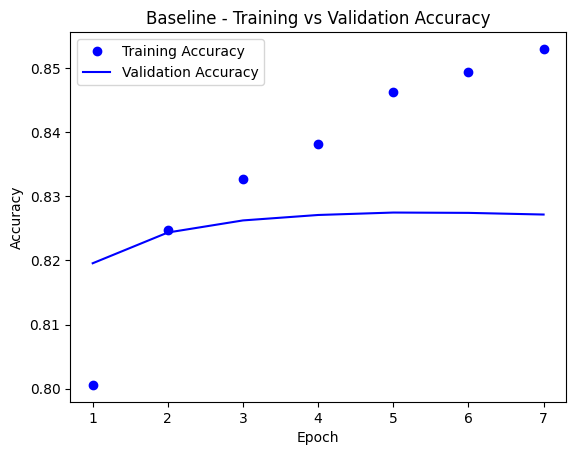

In [17]:
plot_history(history0, title_prefix="Baseline")

#Iteration 1 (add L2 regularization)

The model is overfitting pretty badly, even with learning rate adjust ReduceLROnPlateau callback, which should adjust the learning rate dynamically. Here I'm adding L2 regularization to check if that helps with overfitting.

In [18]:
l2_reg = 1e-3

X_train_pad, X_val_pad, X_test_pad, tokenizer = tokenize_and_pad(
    x_train   = X_train,
    x_val     = X_val,
    x_test    = X_test,
    max_words = MAX_WORDS,
    max_len   = MAX_LEN
    )
model1, history1 = build_and_train_model(
    x_train_pad     = X_train_pad,
    y_train         = y_train,
    x_val_pad       = X_val_pad,
    y_val           = y_val,
    max_words       = MAX_WORDS,
    max_len         = MAX_LEN,
    epochs          = EPOCHS,
    batch_size      = BATCH_SIZE,
    reg             = l2_reg,
    spatial_dropout = SPATIAL_DROPOUT
    )

Epoch 1/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.7692 - loss: 0.5078 - val_accuracy: 0.8124 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 2/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8160 - loss: 0.4107 - val_accuracy: 0.8191 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 3/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8255 - loss: 0.3945 - val_accuracy: 0.8205 - val_loss: 0.3991 - learning_rate: 0.0010
Epoch 4/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8314 - loss: 0.3838 - val_accuracy: 0.8216 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 5/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8366 - loss: 0.3741 - val_accuracy: 0.8216 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 6/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8420 - loss: 0.3636 - val_accuracy: 0.8216 - val_loss: 0.4042 - learning_rate: 5.0000e-04
Epoch 7/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy:

In [19]:
test_loss1, test_acc1 = evaluate_model(model1, X_test_pad, y_test)

y_prob1, y_pred1 = predict_and_evaluate(model1, X_test_pad, y_test)

4943/4943 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8218 - loss: 0.3975

Test accuracy: 0.8205 | Test loss: 0.3992
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step



[Model 1] Test Accuracy: 0.8205
              precision    recall  f1-score   support

           0     0.8320    0.8028    0.8171     79019
           1     0.8098    0.8381    0.8237     79128

    accuracy                         0.8205    158147
   macro avg     0.8209    0.8205    0.8204    158147
weighted avg     0.8209    0.8205    0.8204    158147



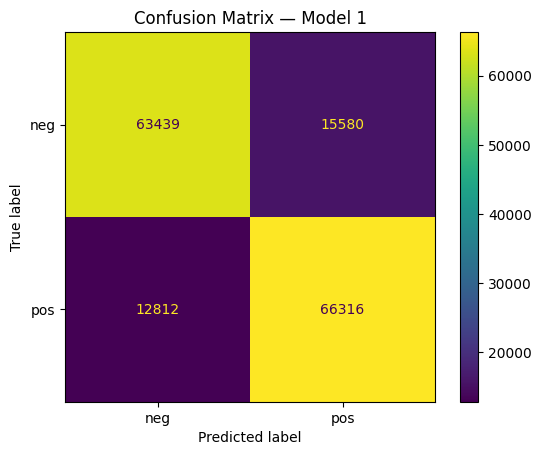

In [20]:
eval_and_viz("Model 1", y_test, y_prob1, y_pred1)

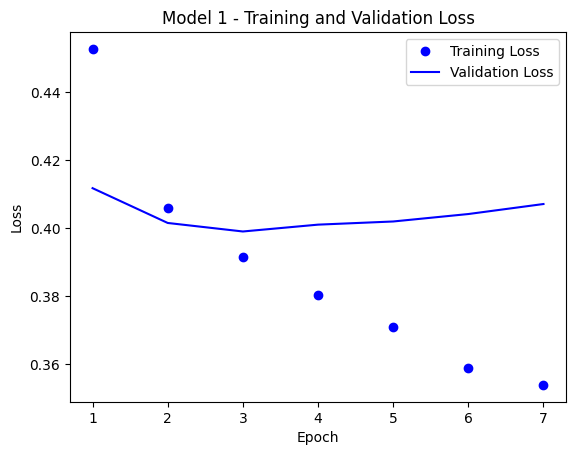

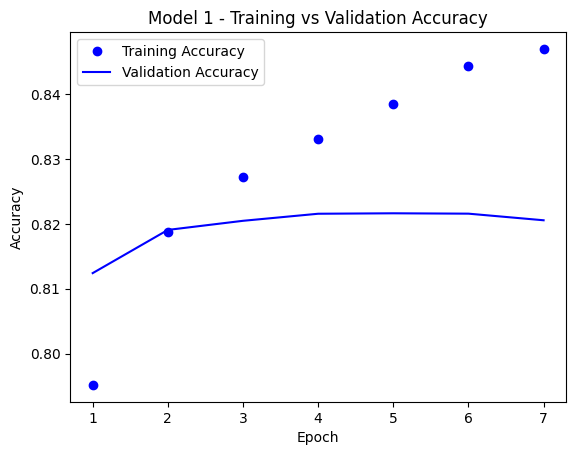

In [21]:
plot_history(history1, title_prefix="Model 1")

# Iteration 2 (adjust MAX_LEN)

The baseline model took MAX_LEN value of 40. This is a nod to when twitter only allowed 40 words in a tweet. This concept however is outdated and we have more than that per tweet as we discovered during EDA.

For this dataset, the longest tweet is 374 words. However, on average, it's around 74 words. In this model, I'll adjust MAX_LEN to be 74 to match the mean tweet size.

In [22]:
MAX_LEN = 50

X_train_pad, X_val_pad, X_test_pad, tokenizer = tokenize_and_pad(
    x_train   = X_train,
    x_val     = X_val,
    x_test    = X_test,
    max_words = MAX_WORDS,
    max_len   = MAX_LEN
    )
model2, history2 = build_and_train_model(
    x_train_pad     = X_train_pad,
    y_train         = y_train,
    x_val_pad       = X_val_pad,
    y_val           = y_val,
    max_words       = MAX_WORDS,
    max_len         = MAX_LEN,
    epochs          = EPOCHS,
    batch_size      = BATCH_SIZE,
    reg             = l2_reg,
    spatial_dropout = SPATIAL_DROPOUT
    )

Epoch 1/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.7687 - loss: 0.5080 - val_accuracy: 0.8117 - val_loss: 0.4120 - learning_rate: 0.0010
Epoch 2/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.8156 - loss: 0.4111 - val_accuracy: 0.8179 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 3/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.8251 - loss: 0.3949 - val_accuracy: 0.8202 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 4/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.8315 - loss: 0.3838 - val_accuracy: 0.8213 - val_loss: 0.3985 - learning_rate: 0.0010
Epoch 5/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.8368 - loss: 0.3743 - val_accuracy: 0.8210 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 6/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.8417 - loss: 0.3660 - val_accuracy: 0.8197 - val_loss: 0.4061 - learning_rate: 0.0010
Epoch 7/15
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accura

In [23]:
test_loss2, test_acc2 = evaluate_model(model2, X_test_pad, y_test)

y_prob2, y_pred2 = predict_and_evaluate(model2, X_test_pad, y_test)


4943/4943 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8220 - loss: 0.3972

Test accuracy: 0.8206 | Test loss: 0.3989
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



[Iteration 2] Test Accuracy: 0.8206
              precision    recall  f1-score   support

           0     0.8307    0.8050    0.8176     79019
           1     0.8111    0.8362    0.8234     79128

    accuracy                         0.8206    158147
   macro avg     0.8209    0.8206    0.8205    158147
weighted avg     0.8209    0.8206    0.8205    158147



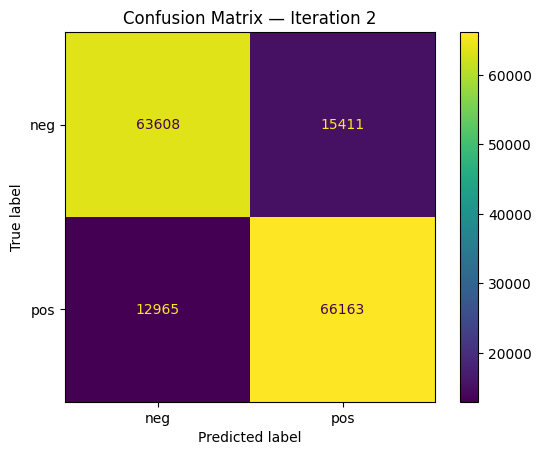

In [24]:
eval_and_viz("Iteration 2", y_test, y_prob2, y_pred2)

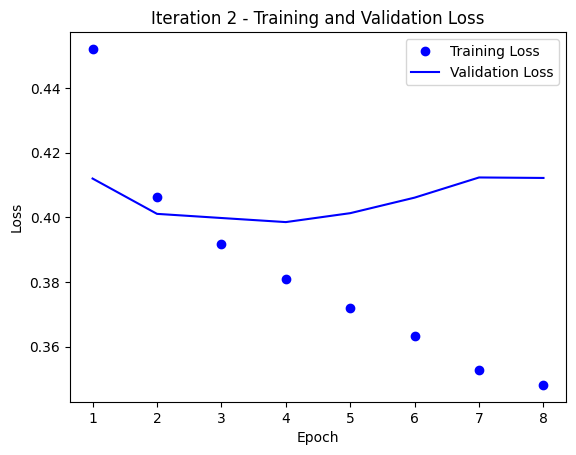

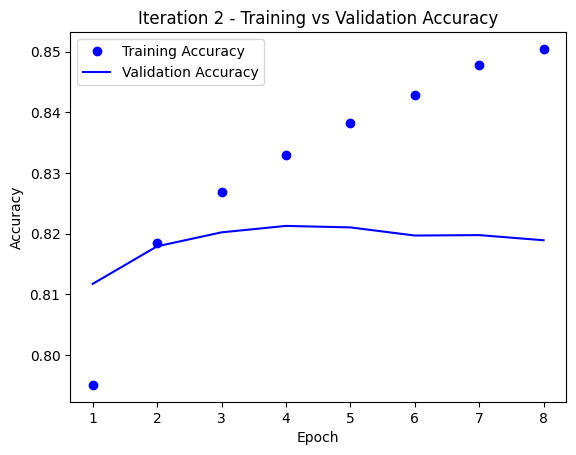

In [25]:
plot_history(history2, title_prefix="Iteration 2")

# Iteration 3 (adjust batch_size)

In this section, I'm taking the best MAX_LEN from the previous two models and adjusting the batch_size to verify what type of improvements I can make.

In [26]:
BATCH_SIZE = 258

X_train_pad, X_val_pad, X_test_pad, tokenizer = tokenize_and_pad(
    x_train   = X_train,
    x_val     = X_val,
    x_test    = X_test,
    max_words = MAX_WORDS,
    max_len   = MAX_LEN
    )
model3, history3 = build_and_train_model(
    x_train_pad     = X_train_pad,
    y_train         = y_train,
    x_val_pad       = X_val_pad,
    y_val           = y_val,
    max_words       = MAX_WORDS,
    max_len         = MAX_LEN,
    epochs          = EPOCHS,
    batch_size      = BATCH_SIZE,
    reg             = l2_reg,
    spatial_dropout = SPATIAL_DROPOUT
    )

Epoch 1/15
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - accuracy: 0.7756 - loss: 0.4885 - val_accuracy: 0.8161 - val_loss: 0.4060 - learning_rate: 0.0010
Epoch 2/15
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8186 - loss: 0.4070 - val_accuracy: 0.8205 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 3/15
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8269 - loss: 0.3924 - val_accuracy: 0.8220 - val_loss: 0.3964 - learning_rate: 0.0010
Epoch 4/15
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8323 - loss: 0.3824 - val_accuracy: 0.8226 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 5/15
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8378 - loss: 0.3737 - val_accuracy: 0.8216 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 6/15
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8422 - loss: 0.3634 - val_accuracy: 0.8211 - val_loss: 0.4033 - learning_rate: 5.0000e-04
Epoch 7/15
4904/4904 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - ac

In [27]:
test_loss3, test_acc3 = evaluate_model(model3, X_test_pad, y_test)

y_prob3, y_pred3 = predict_and_evaluate(model3, X_test_pad, y_test)

4943/4943 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8239 - loss: 0.3950

Test accuracy: 0.8220 | Test loss: 0.3966
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



[Iteration 3] Test Accuracy: 0.8220
              precision    recall  f1-score   support

           0     0.8216    0.8224    0.8220     79019
           1     0.8225    0.8217    0.8221     79128

    accuracy                         0.8220    158147
   macro avg     0.8220    0.8220    0.8220    158147
weighted avg     0.8220    0.8220    0.8220    158147



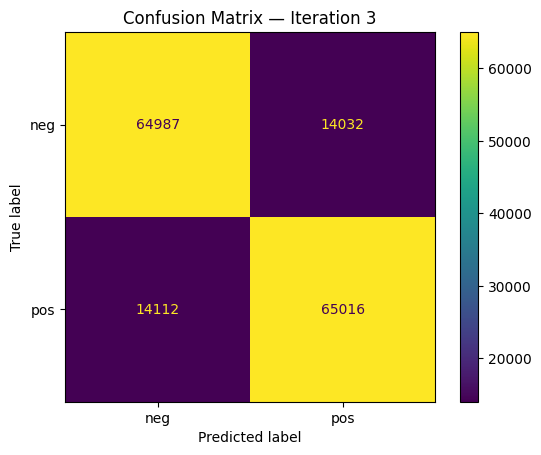

In [28]:
eval_and_viz("Iteration 3", y_test, y_prob3, y_pred3)

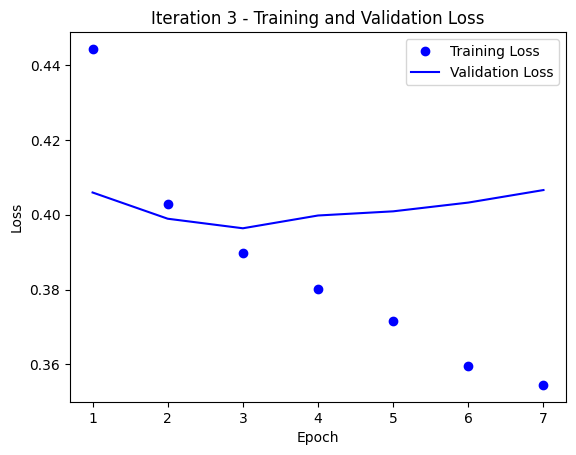

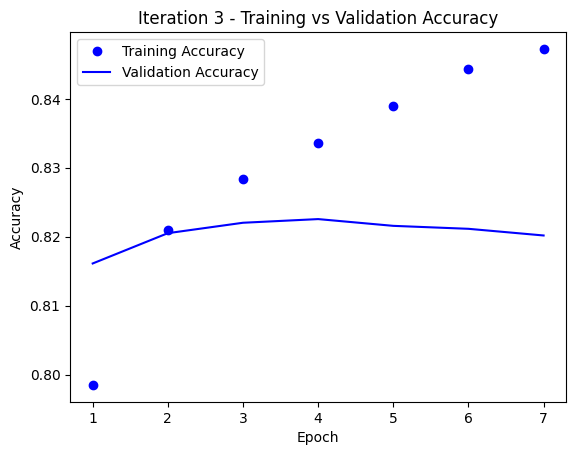

In [29]:
plot_history(history3, title_prefix="Iteration 3")

# Compare models

In [30]:
results_df = pd.DataFrame({
    "model": ["baseline", "model_1", "model_2", "model_3"],
    "test_loss": [test_loss0, test_loss1, test_loss2, test_loss3],
    "test_accuracy": [test_acc0, test_acc1, test_acc2, test_acc3],
})

results_df

,model,test_loss,test_accuracy
0,baseline,0.385427,0.826263
1,model_1,0.399216,0.820471
2,model_2,0.398850,0.820572
3,model_3,0.396592,0.822039


# Analyze Errors

In [31]:
# examine misclassified tweets
pd.set_option('display.max_colwidth', None)
errors_df = pd.DataFrame({
    "text": X_test,
    "true": y_test,
    "pred": y_pred3,
    "prob_pos": y_prob3
})

errors = errors_df[errors_df["true"] !=  errors_df["pred"]].copy()

# Grab a few "most confident wrong" and a few "least confident wrong"
errors["conf"] = np.where(errors["pred"] == 1, errors["prob_pos"], 1 - errors["prob_pos"])
most_conf_wrong = errors.sort_values("conf", ascending=False).head(10)
least_conf_wrong = errors.sort_values("conf", ascending=True).head(10)

print("\nMost confident wrong (10):")
display(most_conf_wrong[["true","pred","prob_pos","text"]])

print("\nLeast confident wrong (10):")
display(least_conf_wrong[["true","pred","prob_pos","text"]])


Most confident wrong (10):


,true,pred,prob_pos,text
112942,0,1,0.998950,"thanks for an awesome season, liverpool fc."
16284,0,1,0.998625,happy birthday fc
51797,0,1,0.998602,good morning mcdonald's iced mocha! ...good morning mcdonald's ice mocha coffee catastrophe!...
58505,0,1,0.998519,"movie night with my sister and the pups, so exciting"
73356,0,1,0.998396,feedback the bonus and promotion to 35 member
90472,0,1,0.998354,"<USER> oooh . you are very welcome, anytime becks"
112488,0,1,0.998131,<USER> haha thanks for caring julia! loll
92785,0,1,0.997997,hah thank youu.
122765,0,1,0.997888,"gonna watch a movie wiwth mom, clare and daniel!! exciting... daddy's in toronto"
122442,0,1,0.997856,annnnd...game one to detroit we'll see how the old timers on that team handle a quick turn around for game 2!!



Least confident wrong (10):


,true,pred,prob_pos,text
38905,1,0,0.499988,<USER> twitter away!
114375,0,1,0.500013,"busy busy! meeting suppliers,manufacturers and sourcing!! to top it off, what a great weather to work."
153824,0,1,0.500015,<USER> ahhhhhhhahahaah. yo will man. i miss ya ima send u an event ting through on fbook. okieeeee
39816,0,1,0.500023,<URL> i'm gonna miss these guys so much thanks for making the 5 years at senior school amazing!
26511,1,0,0.499973,this should be a fun day. out all day and back tomorrow probably
22945,1,0,0.499972,<USER> fuck you
63406,1,0,0.499972,<USER> fuck you
139472,0,1,0.500039,"i think im obsessed with peter, i dont think its that noticable though! lol or maybe it is my mum+dads going to carlisle on july! :-d"
64275,1,0,0.499957,cleaning my car haha
57893,1,0,0.499951,"<USER> mmmmm please don't be sad! don't actually know you, but also don't like it when your sad! double smiles!!"
